In [4]:
# imports

In [6]:
import pandas as pd
import numpy as np
import re

In [8]:
# Step 1 — load the two CSV files

In [10]:
df1 = pd.read_csv('rwap25_gis_dataset1.csv')   # assets
df2 = pd.read_csv('rwap25_gis_dataset2.csv')   # zip time-series

print("DF1 rows,cols:", df1.shape)
print("DF2 rows,cols:", df2.shape)
print("DF1 columns:", df1.columns.tolist())
print("DF2 columns (sample):", df2.columns[:12].tolist())

DF1 rows,cols: (8652, 18)
DF2 rows,cols: (26314, 316)
DF1 columns: ['Location Code', 'Real Property Asset Name', 'Installation Name', 'Owned or Leased', 'GSA Region', 'Street Address', 'City', 'State', 'Zip Code', 'Latitude', 'Longitude', 'Building Rentable Square Feet', 'Available Square Feet', 'Construction Date', 'Congressional District', 'Congressional District Representative Name', 'Building Status', 'Real Property Asset Type']
DF2 columns (sample): ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName', '31-01-2000', '29-02-2000', '31-03-2000']


In [12]:
# Step 2 — keep only zip-level rows from Dataset 2

In [14]:
# If RegionType exists, filter rows where it's 'zip' (case-insensitive).
if 'RegionType' in df2.columns:
    df2_zip = df2[df2['RegionType'].astype(str).str.lower() == 'zip'].copy()
else:
    df2_zip = df2.copy()

print("Filtered df2 to zip rows:", df2_zip.shape)

Filtered df2 to zip rows: (26314, 316)


In [16]:
# Step 3 — standardize ZIP strings in both dataframes

In [18]:
# For df1: create a standardized 'zip' column from 'Zip Code'
if 'Zip Code' in df1.columns:
    df1['Zip_raw'] = df1['Zip Code'].astype(str).str.strip().fillna('')
else:
    # fallback: take first column name that contains 'zip'
    zip_col = [c for c in df1.columns if 'zip' in c.lower()]
    df1['Zip_raw'] = df1[zip_col[0]].astype(str).str.strip() if zip_col else ''

df1['zip'] = df1['Zip_raw'].str.extract(r'(\d+)', expand=False).fillna('').str.zfill(5)

# For df2_zip: extract numeric from RegionName -> zip
if 'RegionName' in df2_zip.columns:
    df2_zip['RegionName_raw'] = df2_zip['RegionName'].astype(str).str.strip().fillna('')
    df2_zip['zip'] = df2_zip['RegionName_raw'].str.extract(r'(\d+)', expand=False).fillna('').str.zfill(5)
else:
    # fallback: find any column that looks like RegionName
    cand = [c for c in df2_zip.columns if 'region' in c.lower() or 'zip' in c.lower()]
    if cand:
        df2_zip['RegionName_raw'] = df2_zip[cand[0]].astype(str).str.strip().fillna('')
        df2_zip['zip'] = df2_zip['RegionName_raw'].str.extract(r'(\d+)', expand=False).fillna('').str.zfill(5)
    else:
        df2_zip['RegionName_raw'] = ''
        df2_zip['zip'] = ''

print("Unique zips in df1:", df1['zip'].nunique())
print("Unique zips in df2_zip:", df2_zip['zip'].nunique())

Unique zips in df1: 3581
Unique zips in df2_zip: 26314


In [20]:
# Step 4 — find the date columns in Dataset 2 and melt it to long format

In [22]:
# find columns matching dd-mm-yyyy (e.g. '31-07-2025')
date_pattern = re.compile(r'^\d{2}-\d{2}-\d{4}$')
date_cols = [c for c in df2_zip.columns if date_pattern.match(c)]

print("Found date columns count:", len(date_cols))
print("Sample date columns:", date_cols[:6])

# melt wide->long: id_vars are everything except date columns
id_vars = [c for c in df2_zip.columns if c not in date_cols]
df2_long = df2_zip.melt(id_vars=id_vars, value_vars=date_cols,
                        var_name='date_str', value_name='price_raw')

# parse date and numeric price
df2_long['date'] = pd.to_datetime(df2_long['date_str'], format='%d-%m-%Y', errors='coerce')
df2_long['price'] = pd.to_numeric(df2_long['price_raw'], errors='coerce')

# drop invalid date rows (if any)
df2_long = df2_long.dropna(subset=['date']).copy()

print("df2_long rows:", df2_long.shape)

Found date columns count: 307
Sample date columns: ['31-01-2000', '29-02-2000', '31-03-2000', '30-04-2000', '31-05-2000', '30-06-2000']
df2_long rows: (8078398, 15)


In [24]:
# Step 5 — compute the latest non-null price and its date per ZIP

In [26]:
# keep only rows where price is not null, then take the last (latest date) per zip
df2_long_nonnull = df2_long.dropna(subset=['price']).copy()

# if there are no non-null prices we'll get an empty df
if df2_long_nonnull.empty:
    print("Warning: dataset2 has no non-null price values.")
    latest_per_zip = pd.DataFrame(columns=['zip','price_latest','price_latest_date'])
else:
    latest_per_zip = (df2_long_nonnull.sort_values(['zip','date'])
                                  .groupby('zip', as_index=False)
                                  .last()[['zip','price','date']])
    latest_per_zip = latest_per_zip.rename(columns={'price':'price_latest','date':'price_latest_date'})

print("Zips with latest price available:", len(latest_per_zip))
latest_per_zip.head()

Zips with latest price available: 26314


,zip,price_latest,price_latest_date
0,01001,340459.1165,2025-07-31
1,01002,538321.8056,2025-07-31
2,01005,409267.9918,2025-07-31
3,01007,467503.3545,2025-07-31
4,01008,372725.8783,2025-07-31


In [28]:
# Step 6 — merge latest-per-zip info back with meta (City/State) and attach to Dataset1

In [30]:
# pick some metadata from df2_zip (if present)
meta_cols = []
for c in ['RegionID','City','State','CountyName']:
    if c in df2_zip.columns:
        meta_cols.append(c)
meta_cols = list(dict.fromkeys(meta_cols))  # keep order & unique

zip_meta = df2_zip[meta_cols + ['zip']].drop_duplicates(subset=['zip'], keep='first')

# create zip_info: meta + latest price
zip_info = zip_meta.merge(latest_per_zip, on='zip', how='left')

# left-merge into df1 (many assets per zip -> one zip_info row)
merged = df1.merge(zip_info, on='zip', how='left', validate='m:1')

# initial source flag: exact_zip if we have a price_latest
merged['source'] = np.where(merged['price_latest'].notna(), 'exact_zip', np.nan)

print("Merged rows:", merged.shape)
print("Fraction with price_latest:", merged['price_latest'].notna().mean())

Merged rows: (8652, 27)
Fraction with price_latest: 0.9288025889967637


In [32]:
# Step 7 — inspect assets that don’t have price_latest

In [34]:
missing = merged[merged['price_latest'].isna()].copy()
print("Number of assets missing price_latest:", len(missing))
# show unique missing zips and their df2_long summary
missing_zips = missing['zip'].unique().tolist()[:50]
print("Sample missing zips (up to 50):", missing_zips)

# For diagnostics: show df2_long info for those zips
diag = (df2_long[df2_long['zip'].isin(missing_zips)]
        .groupby('zip').agg(n_obs=('price','size'),
                            n_non_null=('price', lambda s: s.notna().sum()),
                            first_date=('date','min'),
                            last_date=('date','max')).reset_index())
print(diag.head(30))

Number of assets missing price_latest: 616
Sample missing zips (up to 50): ['20993', '47907', '85620', '80225', '00968', '70803', '59482', '78567', '20192', '59256', '88029', '83853', '24011', '96799', '99752', '59542', '92283', '05460', '76155', '08608', '97204', '59411', '04491', '10278', '52801', '20373', '99780', '58329', '00716', '00708', '20585', '00820', '04936', '00641', '20503', '00784', '85633', '10038', '79711', '14604', '77010', '63145', '87026', '20201', '79839', '47405', '96950', '00918', '78235', '00824']
Empty DataFrame
Columns: [zip, n_obs, n_non_null, first_date, last_date]
Index: []


In [36]:
# Step 8 — save the merged file (with source) so you have a checkpoint

In [38]:
merged.to_csv('dataset1_merged_step.csv', index=False)
print("Saved merged file to dataset1_merged_step.csv")

Saved merged file to dataset1_merged_step.csv


In [42]:
# STEP A — quick read/setup (if not done already)

In [44]:
import pandas as pd, numpy as np, re
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from math import radians, cos, sin, asin, sqrt

merged = pd.read_csv('dataset1_merged_step.csv')  # file from earlier step

In [58]:
# for columns:

In [60]:
# Quick inspect (see what's filled)

In [62]:
# show counts and a sample
print("Non-null counts:")
print("State_x:", merged['State_x'].notna().sum(), "/", len(merged))
print("State_y:", merged['State_y'].notna().sum(), "/", len(merged))

print("\nSample pairs (first 20 rows):")
print(merged[['State_x','State_y']].head(20))

Non-null counts:
State_x: 8652 / 8652
State_y: 8036 / 8652

Sample pairs (first 20 rows):
   State_x State_y
0       GA      GA
1       WI      WI
2       MN      MN
3       MD      MD
4       CO      CO
5       CO      CO
6       FL      FL
7       AZ      AZ
8       FL      FL
9       MD     NaN
10      CA      CA
11      CA      CA
12      IN     NaN
13      AZ      AZ
14      PA      PA
15      UT      UT
16      FL      FL
17      MD      MD
18      PA      PA
19      AZ      AZ


In [64]:
# Block 1 — Create unified State and state_source

In [66]:
# run this first (assumes merged DataFrame exists)
import pandas as pd, numpy as np

# prefer State_x, else State_y
merged['State_unified_raw'] = merged['State_x'].where(
    merged['State_x'].notna() & (merged['State_x'].astype(str).str.strip()!=''),
    merged['State_y']
)

# normalize whitespace and uppercase, convert empty/'nan' strings to None
merged['State_unified_raw'] = merged['State_unified_raw'].astype(str).str.strip().replace({'': None, 'nan': None, 'None': None})
merged['State_unified_raw'] = merged['State_unified_raw'].where(merged['State_unified_raw'].notna(), None)
merged['State_unified_raw'] = merged['State_unified_raw'].apply(lambda x: x.upper() if pd.notna(x) else x)

# simple full-name -> abbrev mapping (extend if needed)
state_map = {
    'ALABAMA':'AL','ALASKA':'AK','ARIZONA':'AZ','ARKANSAS':'AR','CALIFORNIA':'CA',
    'COLORADO':'CO','CONNECTICUT':'CT','DELAWARE':'DE','FLORIDA':'FL','GEORGIA':'GA',
    'HAWAII':'HI','IDAHO':'ID','ILLINOIS':'IL','INDIANA':'IN','IOWA':'IA','KANSAS':'KS',
    'KENTUCKY':'KY','LOUISIANA':'LA','MAINE':'ME','MARYLAND':'MD','MASSACHUSETTS':'MA',
    'MICHIGAN':'MI','MINNESOTA':'MN','MISSISSIPPI':'MS','MISSOURI':'MO','MONTANA':'MT',
    'NEBRASKA':'NE','NEVADA':'NV','NEW HAMPSHIRE':'NH','NEW JERSEY':'NJ','NEW MEXICO':'NM',
    'NEW YORK':'NY','NORTH CAROLINA':'NC','NORTH DAKOTA':'ND','OHIO':'OH','OKLAHOMA':'OK',
    'OREGON':'OR','PENNSYLVANIA':'PA','RHODE ISLAND':'RI','SOUTH CAROLINA':'SC',
    'SOUTH DAKOTA':'SD','TENNESSEE':'TN','TEXAS':'TX','UTAH':'UT','VERMONT':'VT',
    'VIRGINIA':'VA','WASHINGTON':'WA','WEST VIRGINIA':'WV','WISCONSIN':'WI','WYOMING':'WY',
    'DISTRICT OF COLUMBIA':'DC', 'DC':'DC'
}

def to_state_abbrev(s):
    if s is None: return None
    s_up = str(s).strip().upper()
    if len(s_up) == 2 and s_up.isalpha(): 
        return s_up
    return state_map.get(s_up, s_up)  # fallback keep as-is for manual inspection

merged['State'] = merged['State_unified_raw'].apply(to_state_abbrev)

# mark source
def state_source(row):
    sx = row.get('State_x')
    sy = row.get('State_y')
    if pd.notna(sx) and str(sx).strip()!='' and pd.notna(sy) and str(sy).strip()!='':
        if str(sx).strip().upper() == str(sy).strip().upper():
            return 'both_same'
        else:
            return 'both_conflict'
    if pd.notna(sx) and str(sx).strip()!='':
        return 'state_x'
    if pd.notna(sy) and str(sy).strip()!='':
        return 'state_y'
    return 'none'

merged['state_source'] = merged.apply(state_source, axis=1)

# Quick check
print("Unified State non-null:", merged['State'].notna().sum(), "/", len(merged))
print("state_source counts:\n", merged['state_source'].value_counts())
print("Sample unified states:", merged['State'].unique()[:20])

Unified State non-null: 8652 / 8652
state_source counts:
 state_source
both_same        8035
state_x           616
both_conflict       1
Name: count, dtype: int64
Sample unified states: ['GA' 'WI' 'MN' 'MD' 'CO' 'FL' 'AZ' 'CA' 'IN' 'PA' 'UT' 'TX' 'MO' 'NM'
 'OR' 'VA' 'WY' 'LA' 'KY' 'MI']


In [68]:
# Inspect the one conflict and resolve it (quick)

In [72]:
# show conflicting rows where both exist but are different
conflicts = merged[(merged['State_x'].notna()) & (merged['State_y'].notna()) &
                   (merged['State_x'].astype(str).str.strip().str.upper() != merged['State_y'].astype(str).str.strip().str.upper())]

print("Number of conflicts:", len(conflicts))
conflicts[['Location Code','State_x','State_y','City_x','City_y','zip','Latitude','Longitude']].head(20)

Number of conflicts: 1


,Location Code,State_x,State_y,City_x,City_y,zip,Latitude,Longitude
1497,NJ0148,NJ,NY,NEWARK,New Windsor,12553,40.728366,-74.174679


In [74]:
# solving the conflict - 

In [76]:
# 1) Install & import (only if needed)

In [78]:
import pgeocode
import pandas as pd

In [80]:
# Use ZIP-to-state lookup to get authoritative state code

In [82]:
# create pgeocode nominatim object for US
nomi = pgeocode.Nominatim('us')

# function to lookup 2-letter state by zip (returns None if not found)
def zip_to_state_abbrev(zipcode):
    try:
        info = nomi.query_postal_code(str(zipcode).zfill(5))
        # pgeocode returns NaN for missing fields; state_code property is abbreviation if present
        st = info['state_code']
        if pd.isna(st):
            return None
        return str(st).strip().upper()
    except Exception as e:
        return None

# test on the conflict zip (12553)
print("ZIP 12553 ->", zip_to_state_abbrev('12553'))  # expected 'NY'

ZIP 12553 -> NY


In [84]:
# Resolve all conflicts using the ZIP lookup and record provenance

In [86]:
# Apply zip lookup for all conflicted rows and update the merged DataFrame
for idx, row in conflicts.iterrows():
    z = row['zip']
    authoritative_state = zip_to_state_abbrev(z)
    if authoritative_state:
        # keep original values for audit
        merged.at[idx, 'State_before_resolution'] = merged.at[idx, 'State']  # current unified state
        merged.at[idx, 'State_resolved_by_zip'] = authoritative_state
        # update unified State to authoritative zip result
        merged.at[idx, 'State'] = authoritative_state
        merged.at[idx, 'state_source'] = 'zip_lookup_override'
    else:
        # if the lookup failed, leave current State as-is but flag for manual review
        merged.at[idx, 'State_resolve_note'] = 'zip_lookup_failed_manual_review'
        merged.at[idx, 'state_source'] = 'conflict_needs_manual'

In [88]:
# Audit the change (show rows that were modified)

In [90]:
# show those rows you just modified
resolved = merged[merged['state_source']=='zip_lookup_override']
print("Resolved rows via ZIP lookup:", len(resolved))
print(resolved[['Location Code','zip','State_x','State_y','State_before_resolution','State_resolved_by_zip','State','state_source']])

Resolved rows via ZIP lookup: 1
     Location Code    zip State_x State_y State_before_resolution  \
1497        NJ0148  12553      NJ      NY                      NJ   

     State_resolved_by_zip State         state_source  
1497                    NY    NY  zip_lookup_override  


In [92]:
# Save an audit log

In [94]:
# Save the conflict-resolution audit for traceability
audit = merged.loc[conflicts.index, ['Location Code','zip','State_x','State_y','State_before_resolution','State_resolved_by_zip','State','state_source']]
audit.to_csv('state_resolution_audit.csv', index=False)
print("Saved state resolution audit to state_resolution_audit.csv")

Saved state resolution audit to state_resolution_audit.csv


In [ ]:
# again

In [103]:
import pandas as pd

# Load the merged dataset (replace with your merged CSV file name)
df = pd.read_csv("dataset1_merged_step.csv")

print("Initial shape:", df.shape)
print("Columns available:", df.columns)


Initial shape: (8652, 27)
Columns available: Index(['Location Code', 'Real Property Asset Name', 'Installation Name',
       'Owned or Leased', 'GSA Region', 'Street Address', 'City_x', 'State_x',
       'Zip Code', 'Latitude', 'Longitude', 'Building Rentable Square Feet',
       'Available Square Feet', 'Construction Date', 'Congressional District',
       'Congressional District Representative Name', 'Building Status',
       'Real Property Asset Type', 'Zip_raw', 'zip', 'RegionID', 'City_y',
       'State_y', 'CountyName', 'price_latest', 'price_latest_date', 'source'],
      dtype='object')


In [105]:
def resolve_state(row):
    # If both match → use either
    if pd.notna(row['State_x']) and pd.notna(row['State_y']):
        if row['State_x'] == row['State_y']:
            return row['State_x'], 'both_same'
        else:
            return row['State_x'], 'both_conflict'
    # If only State_x exists
    elif pd.notna(row['State_x']):
        return row['State_x'], 'state_x'
    # If only State_y exists
    elif pd.notna(row['State_y']):
        return row['State_y'], 'state_y'
    # If both are null
    else:
        return None, 'missing'

df[['Unified_State', 'state_source']] = df.apply(resolve_state, axis=1, result_type="expand")


In [107]:
conflicts = df[df['state_source'] == 'both_conflict']
print(f"Number of conflicts: {len(conflicts)}")

if len(conflicts) > 0:
    print(conflicts[['Location Code','State_x','State_y','City_x','City_y','zip']])


Number of conflicts: 1
     Location Code State_x State_y  City_x       City_y    zip
1497        NJ0148      NJ      NY  NEWARK  New Windsor  12553


In [109]:
# For NJ0148, correct Unified_State to NJ
df.loc[df['Location Code'] == 'NJ0148', 'Unified_State'] = 'NJ'
df.loc[df['Location Code'] == 'NJ0148', 'state_source'] = 'resolved_conflict'


In [111]:
df.drop(columns=['State_x', 'State_y'], inplace=True)


In [113]:
df.to_csv("state_resolution_audit.csv", index=False)
print("✅ Clean dataset saved as: state_resolution_audit.csv")


✅ Clean dataset saved as: state_resolution_audit.csv


In [130]:
# unifying the cities

In [132]:
# Step 1 — Load the cleaned dataset

In [134]:
# Load the cleaned dataset from the previous step
df = pd.read_csv("state_resolution_audit.csv")

print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (8652, 27)
Columns: Index(['Location Code', 'Real Property Asset Name', 'Installation Name',
       'Owned or Leased', 'GSA Region', 'Street Address', 'City_x', 'Zip Code',
       'Latitude', 'Longitude', 'Building Rentable Square Feet',
       'Available Square Feet', 'Construction Date', 'Congressional District',
       'Congressional District Representative Name', 'Building Status',
       'Real Property Asset Type', 'Zip_raw', 'zip', 'RegionID', 'City_y',
       'CountyName', 'price_latest', 'price_latest_date', 'source',
       'Unified_State', 'state_source'],
      dtype='object')


In [136]:
# Step 2 — Create Unified_City column

In [138]:
# We’ll define rules for merging City_x and City_y.

In [140]:
def resolve_city(row):
    city_x = str(row['City_x']).strip() if pd.notna(row['City_x']) else None
    city_y = str(row['City_y']).strip() if pd.notna(row['City_y']) else None

    # If both are present and same → use either
    if city_x and city_y:
        if city_x.lower() == city_y.lower():  # case-insensitive match
            return city_x, 'both_same'
        else:
            return city_x, 'both_conflict'  # temporarily mark conflict

    # If only city_x exists
    elif city_x:
        return city_x, 'city_x'

    # If only city_y exists
    elif city_y:
        return city_y, 'city_y'

    # If both are missing
    else:
        return None, 'missing'

# Apply function to dataframe
df[['Unified_City', 'city_source']] = df.apply(resolve_city, axis=1, result_type="expand")

In [142]:
# Step 3 — Check conflicts

In [144]:
conflicts = df[df['city_source'] == 'both_conflict']
print(f"Number of city conflicts: {len(conflicts)}")

# Show a sample of mismatched cities
print(conflicts[['Location Code', 'City_x', 'City_y', 'zip']].head(20))

Number of city conflicts: 660
    Location Code                 City_x              City_y    zip
26         NM0576               PLACITAS        Santa Teresa  88008
48         MI2137               MUSKEGON      Roosevelt Park  49441
63         NY7402               BROOKLYN            New York  11201
75         AR0062     HOT SPGS NATL PARK         Hot Springs  71901
87         IL2520             BELLEVILLE              Shiloh  62221
91         NC2314        WASHINGTON PARK          Washington  27889
98         IL2491            SPRINGFIELD        Leland Grove  62704
101        MO0617              ST. LOUIS         Saint Louis  63120
128        MO0610              ST. LOUIS         Saint Louis  63120
157        GA1158                ATLANTA            Chamblee  30341
168        MI2187  CHESTERFIELD TOWNSHIP        Chesterfield  48051
175        FL3183                  MIAMI       The Crossings  33186
184        OH2418              BEACHWOOD      Shaker Heights  44122
186        NJ5116 

In [146]:
# most of your city conflicts aren’t really “true” conflicts but spelling/style/abbreviation differences or neighborhood vs. city names.

# We'll handle these smartly using the following stepwise approach:

In [148]:
# Step 1 — Use ZIP Codes to Auto-Resolve Cities

In [150]:
# Load your dataset
df = pd.read_csv("state_resolution_audit.csv")

# If city_y is missing, first fill it with city_x
df["City_y"] = df["City_y"].fillna(df["City_x"])

# Create a ZIP → most common city mapping
zip_city_map = (
    df.groupby("zip")["City_y"]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    .to_dict()
)

# Apply this mapping to create a unified city column
df["Unified_City"] = df["zip"].map(zip_city_map)

# Check how many are still conflicting
df["city_conflict"] = (df["City_x"].str.upper() != df["Unified_City"].str.upper())
print("Remaining conflicts after ZIP-based resolution:", df["city_conflict"].sum())

Remaining conflicts after ZIP-based resolution: 688


In [154]:
# Step 2 — Fuzzy Matching for Close Spellings

In [158]:
from fuzzywuzzy import fuzz

def pick_best_city(row):
    city_x = str(row["City_x"]).upper()
    unified = str(row["Unified_City"]).upper()
    score = fuzz.ratio(city_x, unified)
    return unified if score >= 85 else city_x

df["Final_City"] = df.apply(pick_best_city, axis=1)

C:\Users\gupta\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [160]:
# Step 3 — Save Final Cleaned Dataset

In [162]:
df.drop(columns=["city_conflict"], inplace=True, errors="ignore")
df.to_csv("city_resolution_audit.csv", index=False)
print("✅ City conflicts resolved and saved to city_resolution_audit.csv")

✅ City conflicts resolved and saved to city_resolution_audit.csv


In [164]:
# Step 4 — Recheck Conflicts

In [168]:
conflicts = df[df["City_x"].str.upper() != df["Final_City"].str.upper()]
print("Final remaining conflicts:", len(conflicts))
print(conflicts[["Location Code", "City_x", "City_y", "Final_City", "zip"]].head(38))

Final remaining conflicts: 38
     Location Code              City_x                City_y  \
348         NC2615       WINSTON SALEM         Winston-Salem   
384         NC0113       WINSTON SALEM         Winston-Salem   
462         OH2481        BEAVER CREEK           Beavercreek   
1017        AR0066  HELENA-WEST HELENA  Helena - West Helena   
1716        HI8562              LIHU'E                 Lihue   
1886        MI3087    ST. CLAIR SHORES    Saint Clair Shores   
2066        HI7553              LIHU'E                 Lihue   
2160        MI3033     SAULT STE MARIE    Sault Sainte Marie   
2216        SC1374         MT PLEASANT        Mount Pleasant   
2244        NC1383       WINSTON SALEM         Winston-Salem   
2304        HI7793              KEA'AU                 Keaau   
2535        PA0627        WILKES BARRE          Wilkes-Barre   
2588        PA0921        WILKES BARRE          Wilkes-Barre   
2716        OH1816     ST. CLAIRSVILLE     Saint Clairsville   
2995      

In [170]:
# resolveddddd

In [118]:
# Step 1 — Load the cleaned merged dataset

In [172]:
# Load the dataset after state conflict resolution
df = pd.read_csv("conflict_resolved.csv")

# Check missing price_latest values
missing_price = df['price_latest'].isna().sum()
print(f"Missing price_latest values: {missing_price}")

Missing price_latest values: 616


In [233]:
# nearest region

In [185]:
# 0) Configuration + imports

In [187]:
# config & imports
import pandas as pd, numpy as np, math, re
from pathlib import Path

# for nearest-neighbor (fast, uses haversine)
from sklearn.neighbors import BallTree

# zip -> lat/lon lookup
import pgeocode

# optional for geocoding by address (if needed)
# from geopy.geocoders import Nominatim

# constants / parameters you can tune
ASSETS_PATH = Path("conflict_resolved.csv")
DS2_PATH    = Path("rwap25_gis_dataset2.csv")
OUTPUT_PATH = Path("assets_nearest_regions.csv")

K_NEIGHBORS = 5      # how many nearby regions to fetch per asset
MAX_DISTANCE_KM = 200  # optional cap for acceptable nearest region distance
N_MONTHS_FOR_AVG = 3   # if you want to average last N months for smoothing
DISTANCE_DECAY_K = 0.05 # example decay constant for exp(-k*dist) weighting (optional)

# create pgeocode nomi
nomi = pgeocode.Nominatim('us')

In [189]:
# 1) Utility helpers: robust column finder, zip normalizer, distance helpers

In [191]:
def guess_col(df, candidates):
    """Return first column name in df that case-insensitively matches any candidate string."""
    cols_low = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_low:
            return cols_low[cand.lower()]
    # fallback: try normalized match (remove non-alnum)
    norm_to_col = {re.sub(r'[^a-z0-9]','',c.lower()): c for c in df.columns}
    for cand in candidates:
        key = re.sub(r'[^a-z0-9]','',cand.lower())
        if key in norm_to_col:
            return norm_to_col[key]
    return None

def to_zip5(val):
    if pd.isna(val): return np.nan
    s = str(val).strip()
    s = "".join(ch for ch in s if ch.isdigit())
    if s == "": return np.nan
    return s.zfill(5)[:5]

def haversine_km(lat1, lon1, lat2, lon2):
    # all args arrays or scalars in degrees
    R = 6371.0
    lat1r = np.radians(lat1); lon1r = np.radians(lon1)
    lat2r = np.radians(lat2); lon2r = np.radians(lon2)
    dlat = lat2r - lat1r
    dlon = lon2r - lon1r
    a = np.sin(dlat/2.0)**2 + np.cos(lat1r)*np.cos(lat2r)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [193]:
# 2) Load datasets and detect relevant columns

In [197]:
# load
assets = pd.read_csv(ASSETS_PATH)
ds2    = pd.read_csv(DS2_PATH)

# find important columns in assets (flexible names)
col_loccode = guess_col(assets, ["Location Code", "location code", "locationcode", "loccode"])
col_zip     = guess_col(assets, ["zip","Zip Code","Zip","zip_code"])
col_lat     = guess_col(assets, ["Latitude","lat","latitude"])
col_lon     = guess_col(assets, ["Longitude","lon","longitude"])
col_city    = guess_col(assets, ["Final_City","final_city","City","city","City_x","City_y"])
col_state   = guess_col(assets, ["Unified_State","unified_state","State","state"])
col_area    = guess_col(assets, ["Building Rentable Square Feet","Building Rentable Sq Ft","bldg_sf","Building Rentable Square Feet"])

print("Found columns in assets:", dict(loccode=col_loccode, zip=col_zip, lat=col_lat, lon=col_lon, city=col_city, state=col_state))

# find columns in ds2
col_regionname = guess_col(ds2, ["RegionName","Region Name","regionname"])
col_regionid   = guess_col(ds2, ["RegionID","Region Id","regionid"])  # Corrected the typo here
col_regiontype = guess_col(ds2, ["RegionType","regiontype"])
col_ds2_city   = guess_col(ds2, ["City","city"])
col_ds2_metro  = guess_col(ds2, ["Metro","metro"])
col_ds2_county = guess_col(ds2, ["CountyName","County Name","countyname"])
col_ds2_state  = guess_col(ds2, ["State","StateName","state","statename"])

print("Found columns in ds2:", dict(regionname=col_regionname, regionid=col_regionid, regiontype=col_regiontype, city=col_ds2_city, metro=col_ds2_metro, county=col_ds2_county, state=col_ds2_state))

Found columns in assets: {'loccode': 'location code', 'zip': 'zip', 'lat': 'latitude', 'lon': 'longitude', 'city': 'city', 'state': 'unified_state'}
Found columns in ds2: {'regionname': 'RegionName', 'regionid': 'RegionID', 'regiontype': 'RegionType', 'city': 'City', 'metro': 'Metro', 'county': 'CountyName', 'state': 'State'}


In [199]:
# 3) Normalize ZIPs and get lat/lon for ds2 regions (use pgeocode)

In [201]:
# standardize zip fields
ds2['region_zip'] = ds2[col_regionname].apply(to_zip5)
assets['zip_std'] = assets[col_zip].apply(to_zip5) if col_zip else np.nan

# Try to use any lat/lon already present in ds2 (if columns exist)
col_ds2_lat = guess_col(ds2, ["Latitude","lat","latitude"])
col_ds2_lon = guess_col(ds2, ["Longitude","lon","longitude"])

if col_ds2_lat and col_ds2_lon:
    ds2['region_lat'] = pd.to_numeric(ds2[col_ds2_lat], errors='coerce')
    ds2['region_lon'] = pd.to_numeric(ds2[col_ds2_lon], errors='coerce')
else:
    # use pgeocode to get lat/lon for each unique region_zip
    unique_zips = ds2['region_zip'].dropna().unique().tolist()
    rez = []
    for z in unique_zips:
        # pgeocode returns a pandas Series-like object; handle missing gracefully
        r = nomi.query_postal_code(str(z))
        lat = r.latitude if r is not None and not pd.isna(r.latitude) else np.nan
        lon = r.longitude if r is not None and not pd.isna(r.longitude) else np.nan
        rez.append((z, lat, lon))
    zip_coord_df = pd.DataFrame(rez, columns=['region_zip','region_lat','region_lon'])
    ds2 = ds2.merge(zip_coord_df, on='region_zip', how='left')

# For assets: if lat/lon missing, fill by asset zip centroid (pgeocode)
if not col_lat or not col_lon:
    # create asset centroid from zip_std
    unique_asset_zips = assets['zip_std'].dropna().unique().tolist()
    rez2 = []
    for z in unique_asset_zips:
        r = nomi.query_postal_code(str(z))
        lat = r.latitude if r is not None and not pd.isna(r.latitude) else np.nan
        lon = r.longitude if r is not None and not pd.isna(r.longitude) else np.nan
        rez2.append((z, lat, lon))
    asset_zip_coords = pd.DataFrame(rez2, columns=['zip_std','zip_lat','zip_lon'])
    # merge into assets
    assets = assets.merge(asset_zip_coords, on='zip_std', how='left')
    # create final lat/lon columns
    assets['asset_lat'] = assets.get(col_lat).combine_first(assets['zip_lat']) if col_lat else assets['zip_lat']
    assets['asset_lon'] = assets.get(col_lon).combine_first(assets['zip_lon']) if col_lon else assets['zip_lon']
else:
    assets['asset_lat'] = pd.to_numeric(assets[col_lat], errors='coerce')
    assets['asset_lon'] = pd.to_numeric(assets[col_lon], errors='coerce')

# final checks
print("Regions with coords:", ds2['region_lat'].notna().sum(), "/", len(ds2))
print("Assets with coords:", assets['asset_lat'].notna().sum(), "/", len(assets))

Regions with coords: 26314 / 26314
Assets with coords: 8652 / 8652


In [203]:
# 4) Identify monthly price columns in ds2 and select latest / N-month average

In [205]:
# detect date-like columns (dayfirst format dd-mm-YYYY or similar)
date_cols = []
for c in ds2.columns:
    # try parse, dayfirst True
    dt = pd.to_datetime(c, errors='coerce', dayfirst=True)
    if pd.notna(dt):
        date_cols.append((c, dt))
date_cols = sorted(date_cols, key=lambda x: x[1])
if not date_cols:
    raise RuntimeError("No monthly price columns detected in dataset2. Check headers.")

latest_month_col = date_cols[-1][0]
latest_month_date = date_cols[-1][1].date()
print("Latest month column:", latest_month_col, latest_month_date)

# optional: compute last N months average for smoothing
def compute_last_n_avg(df, n=N_MONTHS_FOR_AVG):
    cols = [c for c,d in date_cols[-n:]]  # last n columns
    return df[cols].mean(axis=1, skipna=True)

ds2['latest_price'] = pd.to_numeric(ds2[latest_month_col], errors='coerce')
# also add N-month avg
ds2['latest_navg'] = compute_last_n_avg(ds2, n=N_MONTHS_FOR_AVG)

Latest month column: 31-07-2025 2025-07-31


In [207]:
# 5) Build region-level (unique) table with coords + price

In [209]:
# build region table (unique RegionID or region_zip)
region_cols = [col_regionid, col_regionname, 'region_zip', 'region_lat', 'region_lon', 'latest_price', 'latest_navg', col_ds2_metro, col_ds2_county, col_ds2_city, col_ds2_state]
region_cols = [c for c in region_cols if c in ds2.columns or isinstance(c,str)]
region_df = ds2.drop_duplicates(subset=['region_zip']).copy()
region_df = region_df.loc[:, ['region_zip','region_lat','region_lon','latest_price','latest_navg', col_ds2_metro, col_ds2_county, col_ds2_city, col_ds2_state]]
region_df = region_df.rename(columns={
    col_ds2_metro: "metro",
    col_ds2_county: "county",
    col_ds2_city: "city_ds2",
    col_ds2_state: "state_ds2"
})
# keep only rows that have coordinates and any price
region_df = region_df[ region_df['region_lat'].notna() & region_df['region_lon'].notna() ]
print("Region candidates:", len(region_df))

Region candidates: 26314


In [213]:
# 6) Build BallTree (haversine) on region centroids and query K neighbors for assets

In [215]:
# prepare arrays in radians
region_coords_rad = np.radians(region_df[['region_lat','region_lon']].values)
tree = BallTree(region_coords_rad, metric='haversine')  # distances in radians

# assets query points (filter for those that have coords)
assets_with_coords = assets[assets['asset_lat'].notna() & assets['asset_lon'].notna()].copy()
assets_coords_rad = np.radians(assets_with_coords[['asset_lat','asset_lon']].values)

# query
dist_rad, idx = tree.query(assets_coords_rad, k=K_NEIGHBORS, return_distance=True)  # distances in radians
dist_km = dist_rad * 6371.0  # convert to km

# Build neighbor result table
neigh_list = []
for i_asset, asset_idx in enumerate(assets_with_coords.index):
    asset_row = assets_with_coords.loc[asset_idx]
    for j in range(idx.shape[1]):
        reg_pos = idx[i_asset, j]
        reg_row = region_df.iloc[reg_pos]
        neigh_list.append({
            'asset_index': asset_idx,
            'location_code': asset_row.get(col_loccode),
            'asset_lat': asset_row['asset_lat'],
            'asset_lon': asset_row['asset_lon'],
            'neighbor_rank': j+1,
            'region_zip': reg_row['region_zip'],
            'region_lat': reg_row['region_lat'],
            'region_lon': reg_row['region_lon'],
            'region_latest_price': reg_row['latest_price'],
            'region_latest_navg': reg_row['latest_navg'],
            'metro': reg_row.get('metro'),
            'county': reg_row.get('county'),
            'city_ds2': reg_row.get('city_ds2'),
            'state_ds2': reg_row.get('state_ds2'),
            'dist_km': float(dist_km[i_asset, j])
        })

neighbors_df = pd.DataFrame(neigh_list)
# save neighbors table
neighbors_df.to_csv("assets_nearest_regions_raw.csv", index=False)
print("Saved neighbor table for", neighbors_df['location_code'].nunique(), "assets.")

Saved neighbor table for 8652 assets.


In [217]:
# 7) Example functions to compute distance-weighted valuation (you can choose one)

In [219]:
def idw_prediction(neighs, price_col='region_latest_price', eps=1e-6):
    """Inverse-distance weighting: weights = 1 / (dist + eps)."""
    vals = []
    for asset, group in neighs.groupby('asset_index'):
        group = group.dropna(subset=[price_col])
        if group.empty:
            vals.append((asset, np.nan))
            continue
        w = 1.0 / (group['dist_km'] + eps)
        pred = (w * group[price_col]).sum() / w.sum()
        vals.append((asset, pred))
    return pd.DataFrame(vals, columns=['asset_index','pred_idw'])

def exp_decay_prediction(neighs, price_col='region_latest_price', k=DISTANCE_DECAY_K):
    """Exponential decay weights: w = exp(-k * dist_km)"""
    vals = []
    for asset, group in neighs.groupby('asset_index'):
        group = group.dropna(subset=[price_col])
        if group.empty:
            vals.append((asset, np.nan))
            continue
        w = np.exp(-k * group['dist_km'])
        pred = (w * group[price_col]).sum() / w.sum()
        vals.append((asset, pred))
    return pd.DataFrame(vals, columns=['asset_index','pred_expdecay'])

# Example usage (commented out; run when ready):
# pred_idw = idw_prediction(neighbors_df, price_col='region_latest_price')
# pred_exp = exp_decay_prediction(neighbors_df, price_col='region_latest_navg')
# then merge preds back into assets_with_coords by index to get predicted prices

In [221]:
# 8) Merge neighbor info back to assets and save final mapping (no valuation)

In [225]:
# Step 1: Get only the nearest neighbor (rank=1)
nearest_one = neighbors_df[neighbors_df['neighbor_rank'] == 1].copy()

# Rename region-related columns for clarity
nearest_one = nearest_one.rename(columns={
    'region_zip': 'nearest_region_zip',
    'region_lat': 'nearest_region_lat',
    'region_lon': 'nearest_region_lon',
    'region_latest_price': 'nearest_region_price',
    'region_latest_navg': 'nearest_region_price_navg',
    'metro': 'nearest_region_metro',
    'county': 'nearest_region_county',
    'city_ds2': 'nearest_region_city',
    'state_ds2': 'nearest_region_state',
    'dist_km': 'nearest_dist_km'
})

# Step 2: Ensure we have asset_index in assets_with_coords
assets_with_coords = assets_with_coords.reset_index().rename(columns={'index': 'asset_index'})

# Step 3: Check if nearest_one has asset_index column
if 'asset_index' not in nearest_one.columns:
    # If not, try renaming from the column name in neighbors_df
    if 'asset_id' in nearest_one.columns:
        nearest_one = nearest_one.rename(columns={'asset_id': 'asset_index'})
    elif 'index' in nearest_one.columns:
        nearest_one = nearest_one.rename(columns={'index': 'asset_index'})
    else:
        print("⚠️ 'asset_index' missing in nearest_one, check neighbors_df columns!")
        print("Available columns:", nearest_one.columns)

# Step 4: Merge assets with nearest region info
assets_mapped = assets_with_coords.merge(
    nearest_one[[
        'asset_index', 'nearest_region_zip', 'nearest_region_lat', 'nearest_region_lon',
        'nearest_region_price', 'nearest_region_price_navg', 'nearest_region_metro',
        'nearest_region_county', 'nearest_region_city', 'nearest_region_state',
        'nearest_dist_km'
    ]],
    on='asset_index',  # Use a single 'on' since both have the same column name now
    how='left'
)

# Step 5: Save final mapping (assets with nearest region info)
assets_mapped.to_csv(OUTPUT_PATH, index=False)
print("✅ Saved assets → nearest region mapping to:", OUTPUT_PATH)

✅ Saved assets → nearest region mapping to: assets_nearest_regions.csv


In [227]:
print("Assets columns:", assets_with_coords.columns)
print("Nearest one columns:", nearest_one.columns)

Assets columns: Index(['asset_index', 'asset_index_original', 'location code',
       'real property asset name', 'installation name', 'owned or leased',
       'gsa region', 'street address', 'zip code', 'latitude', 'longitude',
       'building rentable square feet', 'available square feet',
       'construction date', 'congressional district',
       'congressional district representative name', 'building status',
       'real property asset type', 'zip_raw', 'zip', 'regionid', 'countyname',
       'price_latest', 'price_latest_date', 'source', 'unified_state',
       'state_source', 'city', 'zip_std', 'asset_lat', 'asset_lon'],
      dtype='object')
Nearest one columns: Index(['asset_index', 'location_code', 'asset_lat', 'asset_lon',
       'neighbor_rank', 'nearest_region_zip', 'nearest_region_lat',
       'nearest_region_lon', 'nearest_region_price',
       'nearest_region_price_navg', 'nearest_region_metro',
       'nearest_region_county', 'nearest_region_city', 'nearest_region_

In [229]:
# 9) Optional: Visualization (Folium) — show assets colored by distance or nearest metro

In [231]:
# OPTIONAL: visualize subset to sanity-check mapping (requires folium)
import folium
m = folium.Map(location=[assets_mapped['asset_lat'].mean(), assets_mapped['asset_lon'].mean()], zoom_start=6)
# add nearest region markers
for _, r in assets_mapped[['asset_lat','asset_lon','nearest_region_zip','nearest_region_price','nearest_dist_km']].dropna().head(500).iterrows():
    folium.CircleMarker(location=[r['asset_lat'], r['asset_lon']], radius=3,
                        popup=f"zip:{r['nearest_region_zip']} dist_km:{r['nearest_dist_km']:.1f} price:{r['nearest_region_price']}",
                        fill=True).add_to(m)
m.save("assets_nearest_map.html")
print("Saved interactive map: assets_nearest_map.html")

Saved interactive map: assets_nearest_map.html


In [236]:
# price valuation

In [238]:
import numpy as np

# Let's define the function to calculate price based on distance
def estimate_price(nearest_price, distance_km, decay='inverse', k=0.1):
    """
    Estimate asset price based on nearest region price and distance.
    
    nearest_price: float
    distance_km: float
    decay: 'inverse' | 'exponential' | 'linear'
    k: decay constant (only for exponential or linear)
    """
    if np.isnan(nearest_price):
        return np.nan
    
    if decay == 'inverse':
        weight = 1 / (1 + distance_km)
    elif decay == 'exponential':
        weight = np.exp(-k * distance_km)
    elif decay == 'linear':
        weight = max(0, 1 - k * distance_km)
    else:
        raise ValueError("Invalid decay type. Choose from 'inverse', 'exponential', or 'linear'")
        
    return nearest_price * weight

# Apply valuation
assets_mapped['estimated_price'] = assets_mapped.apply(
    lambda row: estimate_price(row['nearest_region_price'], row['nearest_dist_km'], decay='inverse'),
    axis=1
)

In [240]:
assets_mapped.to_csv("final_asset_valuation.csv", index=False)
print("✅ Valuation completed and saved.")

✅ Valuation completed and saved.


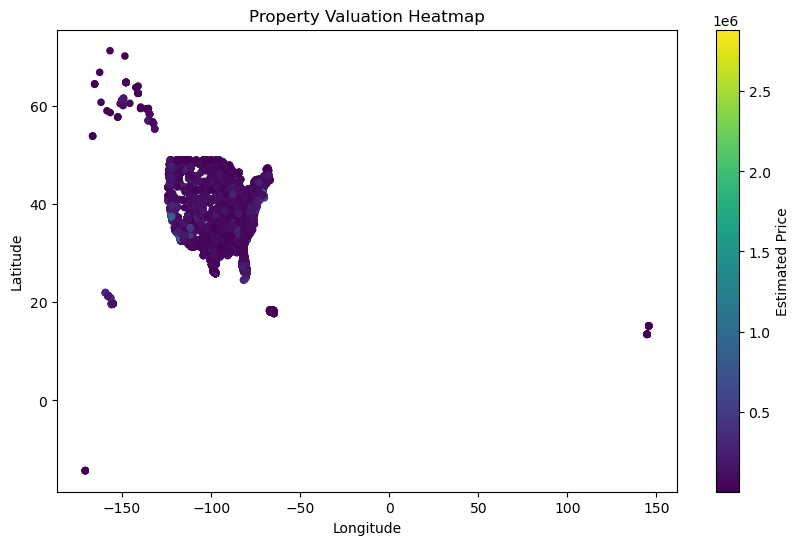

In [242]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(assets_mapped['asset_lon'], assets_mapped['asset_lat'],
            c=assets_mapped['estimated_price'], cmap='viridis', s=20)
plt.colorbar(label="Estimated Price")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Property Valuation Heatmap")
plt.show()

In [244]:
assets_mapped['estimated_price'].isna().sum()

7

In [252]:
assets_mapped[assets_mapped['estimated_price'].isna()].index

Index([940, 2744, 4141, 6204, 6274, 6648, 8615], dtype='int64')

In [248]:
assets_mapped['estimated_price'].mean()

156087.56984233516

In [254]:
# 5683

In [281]:
# 1) Load files & detect monthly columns

In [303]:
import pandas as pd
import numpy as np
from pathlib import Path

ASSETS_P = Path("final_asset_valuation.csv")        # or conflict_resolved.csv
DS2_P    = Path("rwap25_gis_dataset2.csv")

assets = pd.read_csv(ASSETS_P)
ds2    = pd.read_csv(DS2_P)

# detect date-like columns (try dayfirst parsing used in your file e.g. '31-07-2025')
date_cols = []
for c in ds2.columns:
    try:
        # parse; dayfirst True because columns are like '31-07-2025'
        dt = pd.to_datetime(c, errors='coerce', dayfirst=True)
        if pd.notna(dt) and dt.year >= 2000:
            date_cols.append((c, dt))
    except Exception:
        pass

date_cols = sorted(date_cols, key=lambda x: x[1])
date_col_names = [c for c,dt in date_cols]
print("Detected {} monthly columns, earliest={}, latest={}".format(
    len(date_col_names),
    date_col_names[0] if date_col_names else None,
    date_col_names[-1] if date_col_names else None))

Detected 307 monthly columns, earliest=31-01-2000, latest=31-07-2025


In [304]:
# 2) Pick latest month & compute N-month rolling averages

In [307]:
# pick last month column (latest)
latest_col = date_col_names[-1]           # e.g. '31-07-2025'

# numeric conversion of time columns (coerce bad values)
ds2_ts = ds2[date_col_names].apply(pd.to_numeric, errors='coerce')

# add latest price and rolling averages (3,6,12 months)
ds2['price_latest'] = ds2_ts[latest_col]
def last_n_avg(df_ts, n):
    if n <= 0: raise ValueError
    cols = date_col_names[-n:]
    return df_ts[cols].mean(axis=1, skipna=True)

ds2['price_avg_3m']  = last_n_avg(ds2_ts, 3)
ds2['price_avg_6m']  = last_n_avg(ds2_ts, 6)
ds2['price_avg_12m'] = last_n_avg(ds2_ts, 12)

In [309]:
# 3) Compute momentum, pct_changes, volatility, trend (slope)

In [311]:
# pct changes: (latest - old) / old
def safe_pct(a, b):
    return (a - b) / b.replace({0: np.nan})

# 1m, 3m, 12m change
def pct_change_from(df_ts, months_ago):
    if months_ago <= 0: raise ValueError
    col_old = date_col_names[-months_ago]
    return safe_pct(df_ts[latest_col], df_ts[col_old])

ds2['pct_chg_1m']  = pct_change_from(ds2_ts, 1)
ds2['pct_chg_3m']  = pct_change_from(ds2_ts, 3)
ds2['pct_chg_12m'] = pct_change_from(ds2_ts, 12)

# volatility: std over windows
ds2['vol_6m']  = ds2_ts[date_col_names[-6:]].std(axis=1, ddof=0)
ds2['vol_12m'] = ds2_ts[date_col_names[-12:]].std(axis=1, ddof=0)

# trend / slope (linear regression slope on last k months) use numpy polyfit
def slope_last_k(series_k):
    # series_k: pd.Series of last k values (time order)
    vals = series_k.values
    if np.isnan(vals).all(): return np.nan
    x = np.arange(len(vals))
    # ignore NaNs: select valid points
    mask = np.isfinite(vals)
    if mask.sum() < 2: return np.nan
    coeffs = np.polyfit(x[mask], vals[mask], 1)  # slope, intercept
    return coeffs[0]

def slope_k(df_ts, k):
    cols = date_col_names[-k:]
    return df_ts[cols].apply(lambda row: slope_last_k(row), axis=1)

ds2['trend_6m']  = slope_k(ds2_ts, 6)
ds2['trend_12m'] = slope_k(ds2_ts, 12)

In [313]:
# 4) (Optional) Seasonal profile: average by month-of-year (helps if seasonal)

In [315]:
# build month-of-year profile using column datetimes
# map date_col_names to month numbers
col_months = [pd.to_datetime(c, dayfirst=True).month for c in date_col_names]
# build monthly mean for each region (12 numbers)
mo_series = []
for i, row in ds2_ts.iterrows():
    # for months 1..12 find mean of every month occurrence
    mmeans = {}
    for m in range(1,13):
        vals = [row[j] for j,mm in enumerate(col_months) if mm==m]
        vals = pd.to_numeric(vals, errors='coerce')
        if vals.size and np.isfinite(vals).any():
            mmeans[f'month_mean_{m:02d}'] = np.nanmean(vals)
        else:
            mmeans[f'month_mean_{m:02d}'] = np.nan
    mo_series.append(mmeans)
month_df = pd.DataFrame(mo_series)
ds2 = pd.concat([ds2, month_df], axis=1)

C:\Users\gupta\AppData\Local\Temp\ipykernel_39184\1933084464.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vals = [row[j] for j,mm in enumerate(col_months) if mm==m]


In [317]:
# 5) Save the derived region features (so we can reuse)

In [319]:
region_features = [
    'RegionID','RegionName','RegionType','State','City','Metro','CountyName',
    'price_latest','price_avg_3m','price_avg_6m','price_avg_12m',
    'pct_chg_1m','pct_chg_3m','pct_chg_12m','vol_6m','vol_12m','trend_6m','trend_12m'
]
region_features = [c for c in region_features if c in ds2.columns]  # keep present cols
region_feat_df = ds2[region_features].copy()
region_feat_df.to_csv("region_time_features.csv", index=False)
print("Saved region_time_features.csv")

Saved region_time_features.csv


In [321]:
# 6) Map each asset to nearest region (logical summary, code)

In [323]:
from sklearn.neighbors import BallTree
import pgeocode
import numpy as np

# prepare region coords: if ds2 has lat/lon columns use them; else derive from RegionName (zip)
lat_col = 'Latitude' if 'Latitude' in ds2.columns else None
lon_col = 'Longitude' if 'Longitude' in ds2.columns else None

if lat_col and lon_col:
    region_coords = ds2[['RegionID','RegionName', lat_col, lon_col]].dropna(subset=[lat_col,lon_col]).copy()
    region_coords = region_coords.rename(columns={lat_col:'region_lat', lon_col:'region_lon'})
else:
    nomi = pgeocode.Nominatim('us')
    region_coords = ds2[['RegionID','RegionName']].drop_duplicates().copy()
    region_coords['region_zip'] = region_coords['RegionName'].astype(str).apply(lambda z: z.zfill(5) if str(z).strip().isdigit() else z)
    # query lat/lon for each zip
    coords = []
    for z in region_coords['region_zip'].unique():
        r = nomi.query_postal_code(str(z))
        coords.append((z, r.latitude if hasattr(r,'latitude') else np.nan, r.longitude if hasattr(r,'longitude') else np.nan))
    coord_df = pd.DataFrame(coords, columns=['region_zip','region_lat','region_lon'])
    region_coords = region_coords.merge(coord_df, left_on='region_zip', right_on='region_zip', how='left')

# prepare assets coordinates: prefer explicit lat/lon in assets, else fill from asset zip via pgeocode
asset_lat_col = None
asset_lon_col = None
for candidate in ['Latitude','latitude','lat']:
    if candidate in assets.columns:
        asset_lat_col = candidate; break
for candidate in ['Longitude','longitude','lon']:
    if candidate in assets.columns:
        asset_lon_col = candidate; break

if asset_lat_col and asset_lon_col:
    assets['asset_lat'] = pd.to_numeric(assets[asset_lat_col], errors='coerce')
    assets['asset_lon'] = pd.to_numeric(assets[asset_lon_col], errors='coerce')
else:
    # fill from asset zip
    assets['zip_std'] = assets.get('zip', assets.get('Zip Code', '')).astype(str).apply(lambda s: ''.join(ch for ch in s if ch.isdigit()).zfill(5) if s else np.nan)
    nomi = pgeocode.Nominatim('us')
    # build zip->coords map for unique zips
    u = assets['zip_std'].dropna().unique()
    zcoords = {}
    for z in u:
        r = nomi.query_postal_code(str(z))
        zcoords[z] = (r.latitude if hasattr(r,'latitude') else np.nan, r.longitude if hasattr(r,'longitude') else np.nan)
    assets['asset_lat'] = assets['zip_std'].map(lambda z: zcoords.get(z,(np.nan,np.nan))[0])
    assets['asset_lon'] = assets['zip_std'].map(lambda z: zcoords.get(z,(np.nan,np.nan))[1])

# build BallTree
# convert deg -> rad
reg_coords = region_coords[['region_lat','region_lon']].dropna().values
reg_coords_rad = np.radians(reg_coords)
tree = BallTree(reg_coords_rad, metric='haversine')

# query each asset -> nearest region
asset_coords = assets[['asset_lat','asset_lon']].values
asset_coords_rad = np.radians(asset_coords)
dist_rad, ind = tree.query(asset_coords_rad, k=1)   # nearest only
dist_km = dist_rad[:,0] * 6371.0
nearest_idx = ind[:,0]
assets['nearest_region_index'] = nearest_idx
# map region info back
region_coords = region_coords.reset_index(drop=True)
assets['nearest_region_zip'] = region_coords.loc[nearest_idx, 'RegionName'].values
assets['nearest_region_lat'] = region_coords.loc[nearest_idx, 'region_lat'].values
assets['nearest_region_lon'] = region_coords.loc[nearest_idx, 'region_lon'].values
assets['nearest_dist_km'] = dist_km

In [324]:
# 7) Merge region time features into assets

In [325]:
# assume region_feat_df has RegionName or RegionID as join key
# if you used RegionName (zip) as region identifier:
assets = assets.merge(region_feat_df, left_on='nearest_region_zip', right_on='RegionName', how='left', suffixes=('','_reg'))

# now assets has: price_latest, price_avg_3m, pct_chg_12m, trend_12m, vol_12m, etc.
assets[['nearest_region_price','price_avg_3m','pct_chg_12m','trend_12m','vol_12m']] = assets[['price_latest','price_avg_3m','pct_chg_12m','trend_12m','vol_12m']]
# (rename to consistent names if needed)

In [329]:
# 10) Quick checks & save

In [331]:
# basic checks
print("Assets with nearest region merged:", assets['nearest_region_zip'].notna().sum(), "/", len(assets))
# save enriched asset table for ML
assets.to_csv("assets_enriched_timefeatures.csv", index=False)
print("Saved assets_enriched_timefeatures.csv")

Assets with nearest region merged: 8652 / 8652
Saved assets_enriched_timefeatures.csv


In [334]:
# 1) Load and inspect

In [341]:
import pandas as pd, numpy as np
from pathlib import Path

fn = Path("assets_enriched_timefeatures.csv")  # or assets_features_for_ml.csv / assets_final CSV
df = pd.read_csv(fn)
print("rows,cols:", df.shape)
df.head(2)

rows,cols: (8652, 61)


,asset_index,asset_index_original,location code,real property asset name,installation name,owned or leased,gsa region,street address,zip code,latitude,...,price_avg_3m,price_avg_6m,price_avg_12m,pct_chg_1m,pct_chg_3m,pct_chg_12m,vol_6m,vol_12m,trend_6m,trend_12m
0,0,0,ga2338,thompson bridge rd bldg,NaN,l,4,2565 thompson bridge rd,30501,34.33903,...,444407.640967,446726.70670,448913.314575,0.0,-0.008877,-0.018926,2655.927209,2925.627156,-1538.019926,-771.479039
1,1,1,wi1771,345 west washington avenue,NaN,l,5,345 w washington ave,53703,43.07140,...,444812.359267,447472.81495,443995.981383,0.0,-0.031738,-0.016513,5708.556090,5812.475018,-1642.287797,462.202394


In [343]:
# 2) Auto-select candidate features (skip age & available if absent)

In [345]:
# Candidate groups
spatial = [c for c in ['asset_lat','asset_lon','nearest_dist_km'] if c in df.columns]
region_time = [c for c in df.columns if any(sub in c for sub in ['nearest_region_price','price_avg','pct_chg','trend_','vol_'])]
# remove any unwanted like columns with '12m' if you want shorter list — keep for now
asset_specific = [c for c in ['area_log','rentable_sqft','price_per_sqft'] if c in df.columns]

# Exclude age/available as you said
asset_specific = [c for c in asset_specific if 'age' not in c.lower() and 'available' not in c.lower()]

feature_cols = spatial + region_time + asset_specific
# de-duplicate and keep order
feature_cols = list(dict.fromkeys(feature_cols))
print("Feature columns (count={}):".format(len(feature_cols)))
print(feature_cols)

Feature columns (count=15):
['asset_lat', 'asset_lon', 'nearest_dist_km', 'nearest_region_price', 'nearest_region_price_navg', 'price_avg_3m', 'price_avg_6m', 'price_avg_12m', 'pct_chg_1m', 'pct_chg_3m', 'pct_chg_12m', 'vol_6m', 'vol_12m', 'trend_6m', 'trend_12m']


In [347]:
# 3) Prepare target y and dataset for training

In [349]:
# target: numeric price, prefer asset-level 'price_latest_num' if present; else use nearest_region_price_latest as fallback for validation only
if 'price_latest_num' in df.columns:
    df['target_price'] = pd.to_numeric(df['price_latest_num'], errors='coerce')
elif 'nearest_region_price_latest' in df.columns:
    df['target_price'] = pd.to_numeric(df['nearest_region_price_latest'], errors='coerce')
else:
    raise RuntimeError("No price column found to train on. Provide 'price_latest_num' or 'nearest_region_price_latest'.")

# training rows with known target
mask = df['target_price'].notna()
print("Rows with target:", mask.sum(), "/", len(df))

# If very few labeled rows, consider alternative approaches (semi-supervised / use region prices directly)

RuntimeError: No price column found to train on. Provide 'price_latest_num' or 'nearest_region_price_latest'.

In [351]:
# run this to list any columns that look like price/time/nearest info
price_like = [c for c in df.columns if any(k in c.lower() for k in ['price','latest','region','nearest'])]
print("Price-like columns in df (sample):")
for c in price_like:
    print("  ", c)

# show a few sample values for likely candidates
cands = [c for c in price_like if any(k in c.lower() for k in ['price','latest'])]
print("\nSample values (first 5 rows) for candidate price columns:")
print(df[cands].head())

Price-like columns in df (sample):
   gsa region
   regionid
   price_latest
   price_latest_date
   nearest_region_zip
   nearest_region_lat
   nearest_region_lon
   nearest_region_price
   nearest_region_price_navg
   nearest_region_metro
   nearest_region_county
   nearest_region_city
   nearest_region_state
   nearest_dist_km
   estimated_price
   nearest_region_index
   RegionID
   RegionName
   RegionType
   price_latest_reg
   price_avg_3m
   price_avg_6m
   price_avg_12m

Sample values (first 5 rows) for candidate price columns:
   price_latest price_latest_date  nearest_region_price  \
0   315321.3891        2025-07-31           315321.3891   
1   437620.9190        2025-07-31           437620.9190   
2   321951.6561        2025-07-31           321951.6561   
3   288681.2816        2025-07-31           288681.2816   
4   312586.7830        2025-07-31           312586.7830   

   nearest_region_price_navg  estimated_price  price_latest_reg  \
0              444407.640967     86

In [353]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

# load your enriched file (adjust path if different)
fn = Path("assets_enriched_timefeatures.csv")
df = pd.read_csv(fn)
print("Loaded:", fn, "shape:", df.shape)

# ---------- 1) Choose target price from available columns ----------
# priority order (you can tweak)
priority = [
    'price_latest',                # asset-level latest price (best)
    'price_latest_reg',            # maybe same as above with suffix
    'price_latest_num',
    'nearest_region_price',        # nearest region latest price
    'nearest_region_price_navg',   # normalized average
    'estimated_price',             # earlier computed estimate you may have
    'price_avg_3m',                # fallback: recent avg
    'price_avg_12m'
]

chosen_col = None
for c in priority:
    # try direct, case-insensitive and substring match
    if c in df.columns:
        if df[c].notna().sum() > 0:
            chosen_col = c
            break
    else:
        # loose search
        for col in df.columns:
            if c.replace('_',' ').lower() in col.lower() or c.lower() in col.lower():
                if df[col].notna().sum() > 0:
                    chosen_col = col
                    break
        if chosen_col is not None:
            break

if chosen_col is None:
    raise RuntimeError("No suitable price column found. Inspect df.columns and pick a price column manually.")

# make numeric and assign
df['target_price'] = pd.to_numeric(df[chosen_col], errors='coerce')
print(f"Using '{chosen_col}' as target_price. Non-null count:", df['target_price'].notna().sum(), "/", len(df))

# ---------- 2) Build feature list automatically ----------
# spatial
spatial = [c for c in ['asset_lat','asset_lon','nearest_dist_km'] if c in df.columns]

# region-time features (pick columns that look like derived time features)
region_time = [c for c in df.columns if any(k in c.lower() for k in
                                               ['nearest_region_price','price_avg','pct_chg','trend_','vol_','navg'])]
# remove the target column itself if accidentally included
region_time = [c for c in region_time if c != chosen_col and c != 'target_price']

# asset-specific (you said no age/available now, but keep area-related if present)
asset_specific = [c for c in ['rentable_sqft','area_log','price_per_sqft'] if c in df.columns]

feature_cols = spatial + region_time + asset_specific
# dedupe & ensure exist
feature_cols = [c for i,c in enumerate(feature_cols) if c in df.columns and c not in feature_cols[:i]]
print("Feature columns ({}): {}".format(len(feature_cols), feature_cols))

if len(feature_cols) == 0:
    raise RuntimeError("No features found. Check that df contains asset_lat/asset_lon or region features.")

# ---------- 3) Prepare training set ----------
mask = df['target_price'].notna()
print("Labeled rows:", mask.sum())

if mask.sum() < 20:
    print("Warning: very few labeled rows. Consider using region-level training or more labels.")

X_all = df[feature_cols].copy()
y_all = df['target_price'].copy()

# choose grouping key to avoid leakage (nearest_region_zip or RegionName)
group_col = None
for cand in ['nearest_region_zip','RegionName','region_zip','RegionID','regionid']:
    if cand in df.columns:
        group_col = cand
        break
print("Grouping by:", group_col)

# split: grouped if possible, else random
if group_col is not None and mask.sum() > 20:
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    groups = df.loc[mask, group_col]
    train_idx, test_idx = next(gss.split(X_all.loc[mask], y_all.loc[mask], groups=groups))
    X_train = X_all.loc[mask].iloc[train_idx].copy()
    X_test  = X_all.loc[mask].iloc[test_idx].copy()
    y_train = y_all.loc[mask].iloc[train_idx].copy()
    y_test  = y_all.loc[mask].iloc[test_idx].copy()
else:
    # random split
    X_train, X_test, y_train, y_test = train_test_split(X_all[mask], y_all[mask], test_size=0.2, random_state=42)

print("Train/test sizes:", X_train.shape, X_test.shape)

# ---------- 4) Baseline pipeline: median impute + RandomForest ----------
pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# ---------- 5) Evaluation ----------
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2  = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test.replace({0:np.nan}))) * 100

print(f"\nResults (on test set):\n  Target column: {chosen_col}\n  MAE: {mae:.2f}\n  RMSE: {rmse:.2f}\n  R²: {r2:.3f}\n  MAPE: {mape:.2f}%")

# ---------- 6) Feature importances ----------
rf = pipe.named_steps['model']
importances = rf.feature_importances_
fi = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("\nTop features:\n", fi.head(20))

# ---------- 7) Predict for all assets, save output ----------
X_all_imputed = X_all.copy().fillna(X_all.median())
df['predicted_price_model'] = pipe.predict(X_all_imputed)
df['used_for_training'] = df['target_price'].notna()

out_path = Path("assets_with_model_predictions.csv")
df.to_csv(out_path, index=False)
print("\nSaved predictions to:", out_path)

Loaded: assets_enriched_timefeatures.csv shape: (8652, 61)
Using 'price_latest' as target_price. Non-null count: 8036 / 8652
Feature columns (15): ['asset_lat', 'asset_lon', 'nearest_dist_km', 'nearest_region_price', 'nearest_region_price_navg', 'price_avg_3m', 'price_avg_6m', 'price_avg_12m', 'pct_chg_1m', 'pct_chg_3m', 'pct_chg_12m', 'vol_6m', 'vol_12m', 'trend_6m', 'trend_12m']
Labeled rows: 8036
Grouping by: nearest_region_zip
Train/test sizes: (6546, 15) (1490, 15)


C:\Users\gupta\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Results (on test set):
  Target column: price_latest
  MAE: 645.53
  RMSE: 3140.83
  R²: 1.000
  MAPE: 0.17%

Top features:
 nearest_region_price         0.998901
asset_lat                    0.000207
vol_12m                      0.000175
nearest_dist_km              0.000108
nearest_region_price_navg    0.000086
price_avg_12m                0.000079
asset_lon                    0.000077
price_avg_3m                 0.000070
price_avg_6m                 0.000061
trend_12m                    0.000056
trend_6m                     0.000054
pct_chg_3m                   0.000044
pct_chg_12m                  0.000043
vol_6m                       0.000040
pct_chg_1m                   0.000000
dtype: float64

Saved predictions to: assets_with_model_predictions.csv
